In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [ ]:
import os
import time
import math
import shutil
import pathlib
import itertools
import random
from glob import glob
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Input, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'Image': images_paths, 'Mask': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [ ]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 10


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='Image', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='Mask', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), padding="same")(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    c1 = Conv2D(32, (3, 3), padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding="same")(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)
    c2 = Conv2D(64, (3, 3), padding="same")(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), padding="same")(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)
    c3 = Conv2D(128, (3, 3), padding="same")(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    # Decoder
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), padding="same")(u1)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)
    c4 = Conv2D(64, (3, 3), padding="same")(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), padding="same")(u2)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)
    c5 = Conv2D(32, (3, 3), padding="same")(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c5)

    return Model(inputs, outputs)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [ ]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path)

        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training(hist):
    '''
    This function takes a Keras History object and plots accuracy, dice, and loss with best epochs marked.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_dice = np.argmax(val_dice)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label='Training Dice')
    plt.plot(Epochs, val_dice, 'g', label='Validation Dice')
    plt.scatter(index_dice + 1, dice_highest, s=150, c='blue', label=dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
df = create_df(path+'/kaggle_3m')
train_df , val_df, test_df = split_df(df)

In [ ]:
tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
val_gen = create_gens(val_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

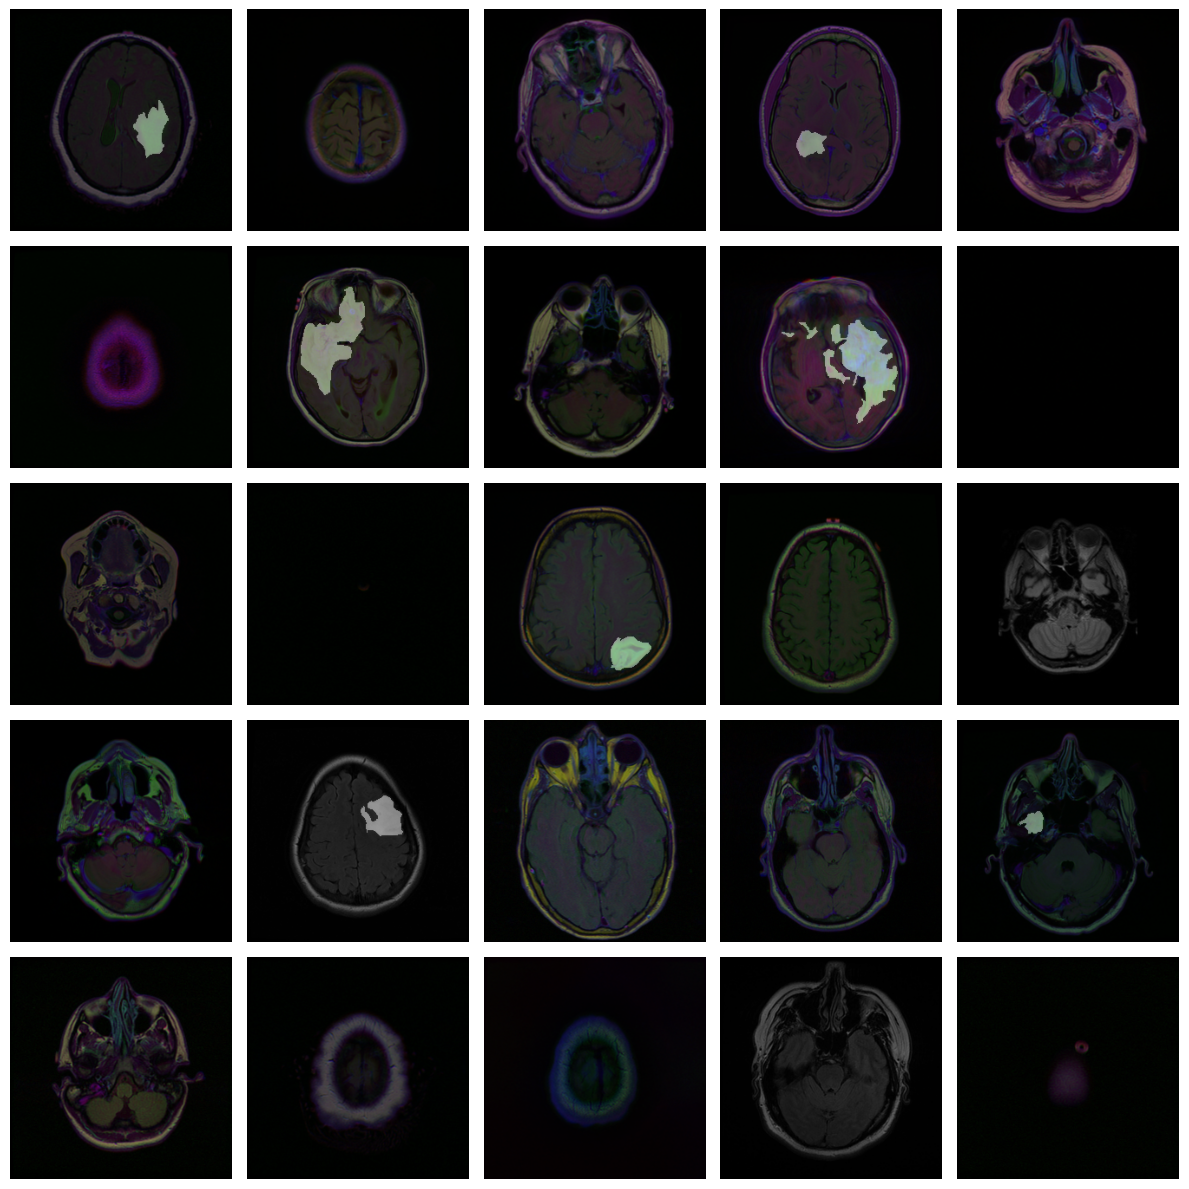

In [ ]:
show_images(list(train_df['Image']), list(train_df['Mask']))

In [ ]:
model = unet()
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=Adam(),
    loss=dice_loss,
    metrics=[dice_coef, 'accuracy']
)

history = model.fit(
          train_gen,
          validation_data=val_gen,
          epochs=30,
          steps_per_epoch=math.ceil(len(train_df) / 10),
          validation_steps=math.ceil(len(val_df) / 10),
          callbacks=[early_stop],
          verbose = 1
          )

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9389 - dice_coef: 0.1928 - loss: 0.8079Found 393 validated image filenames.
Found 393 validated image filenames.
315/315 ━━━━━━━━━━━━━━━━━━━━ 98s 279ms/step - accuracy: 0.9390 - dice_coef: 0.1931 - loss: 0.8076 - val_accuracy: 0.9902 - val_dice_coef: 0.2143 - val_loss: 0.7819
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 78s 247ms/step - accuracy: 0.9897 - dice_coef: 0.4815 - loss: 0.5172 - val_accuracy: 0.9895 - val_dice_coef: 0.4827 - val_loss: 0.5087
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 81s 259ms/step - accuracy: 0.9899 - dice_coef: 0.4990 - loss: 0.5007 - val_accuracy: 0.9893 - val_dice_coef: 0.4811 - val_loss: 0.5104
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - accuracy: 0.9915 - dice_coef: 0.5409 - loss: 0.4597 - val_accuracy: 0.9909 - val_dice_coef: 0.5411 - val_loss: 0.4539
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - accuracy: 0.9913 - dice_coef: 0.5436 - loss: 0.4569 - val_accuracy: 0.990

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
          train_gen,
          validation_data=val_gen,
          epochs=20,
          steps_per_epoch=math.ceil(len(train_df) / 10),
          validation_steps=math.ceil(len(val_df) / 10),
          #callbacks=[early_stop],
          verbose = 1
          )

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - accuracy: 0.9926 - dice_coef: 0.5830 - loss: 0.4152 - val_accuracy: 0.9929 - val_dice_coef: 0.5498 - val_loss: 0.4543
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.9923 - dice_coef: 0.5688 - loss: 0.4311 - val_accuracy: 0.9891 - val_dice_coef: 0.4824 - val_loss: 0.5111
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - accuracy: 0.9925 - dice_coef: 0.6027 - loss: 0.3984 - val_accuracy: 0.9925 - val_dice_coef: 0.5331 - val_loss: 0.4669
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 77s 244ms/step - accuracy: 0.9927 - dice_coef: 0.5955 - loss: 0.4027 - val_accuracy: 0.9900 - val_dice_coef: 0.5447 - val_loss: 0.4585
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 77s 244ms/step - accuracy: 0.9927 - dice_coef: 0.5829 - loss: 0.4171 - val_accuracy: 0.9924 - val_dice_coef: 0.6004 - val_loss: 0.4017
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 77s 243ms/step - accuracy: 0.9931 - dice_coef: 0.6112 - loss: 0.3871 - val_accuracy: 

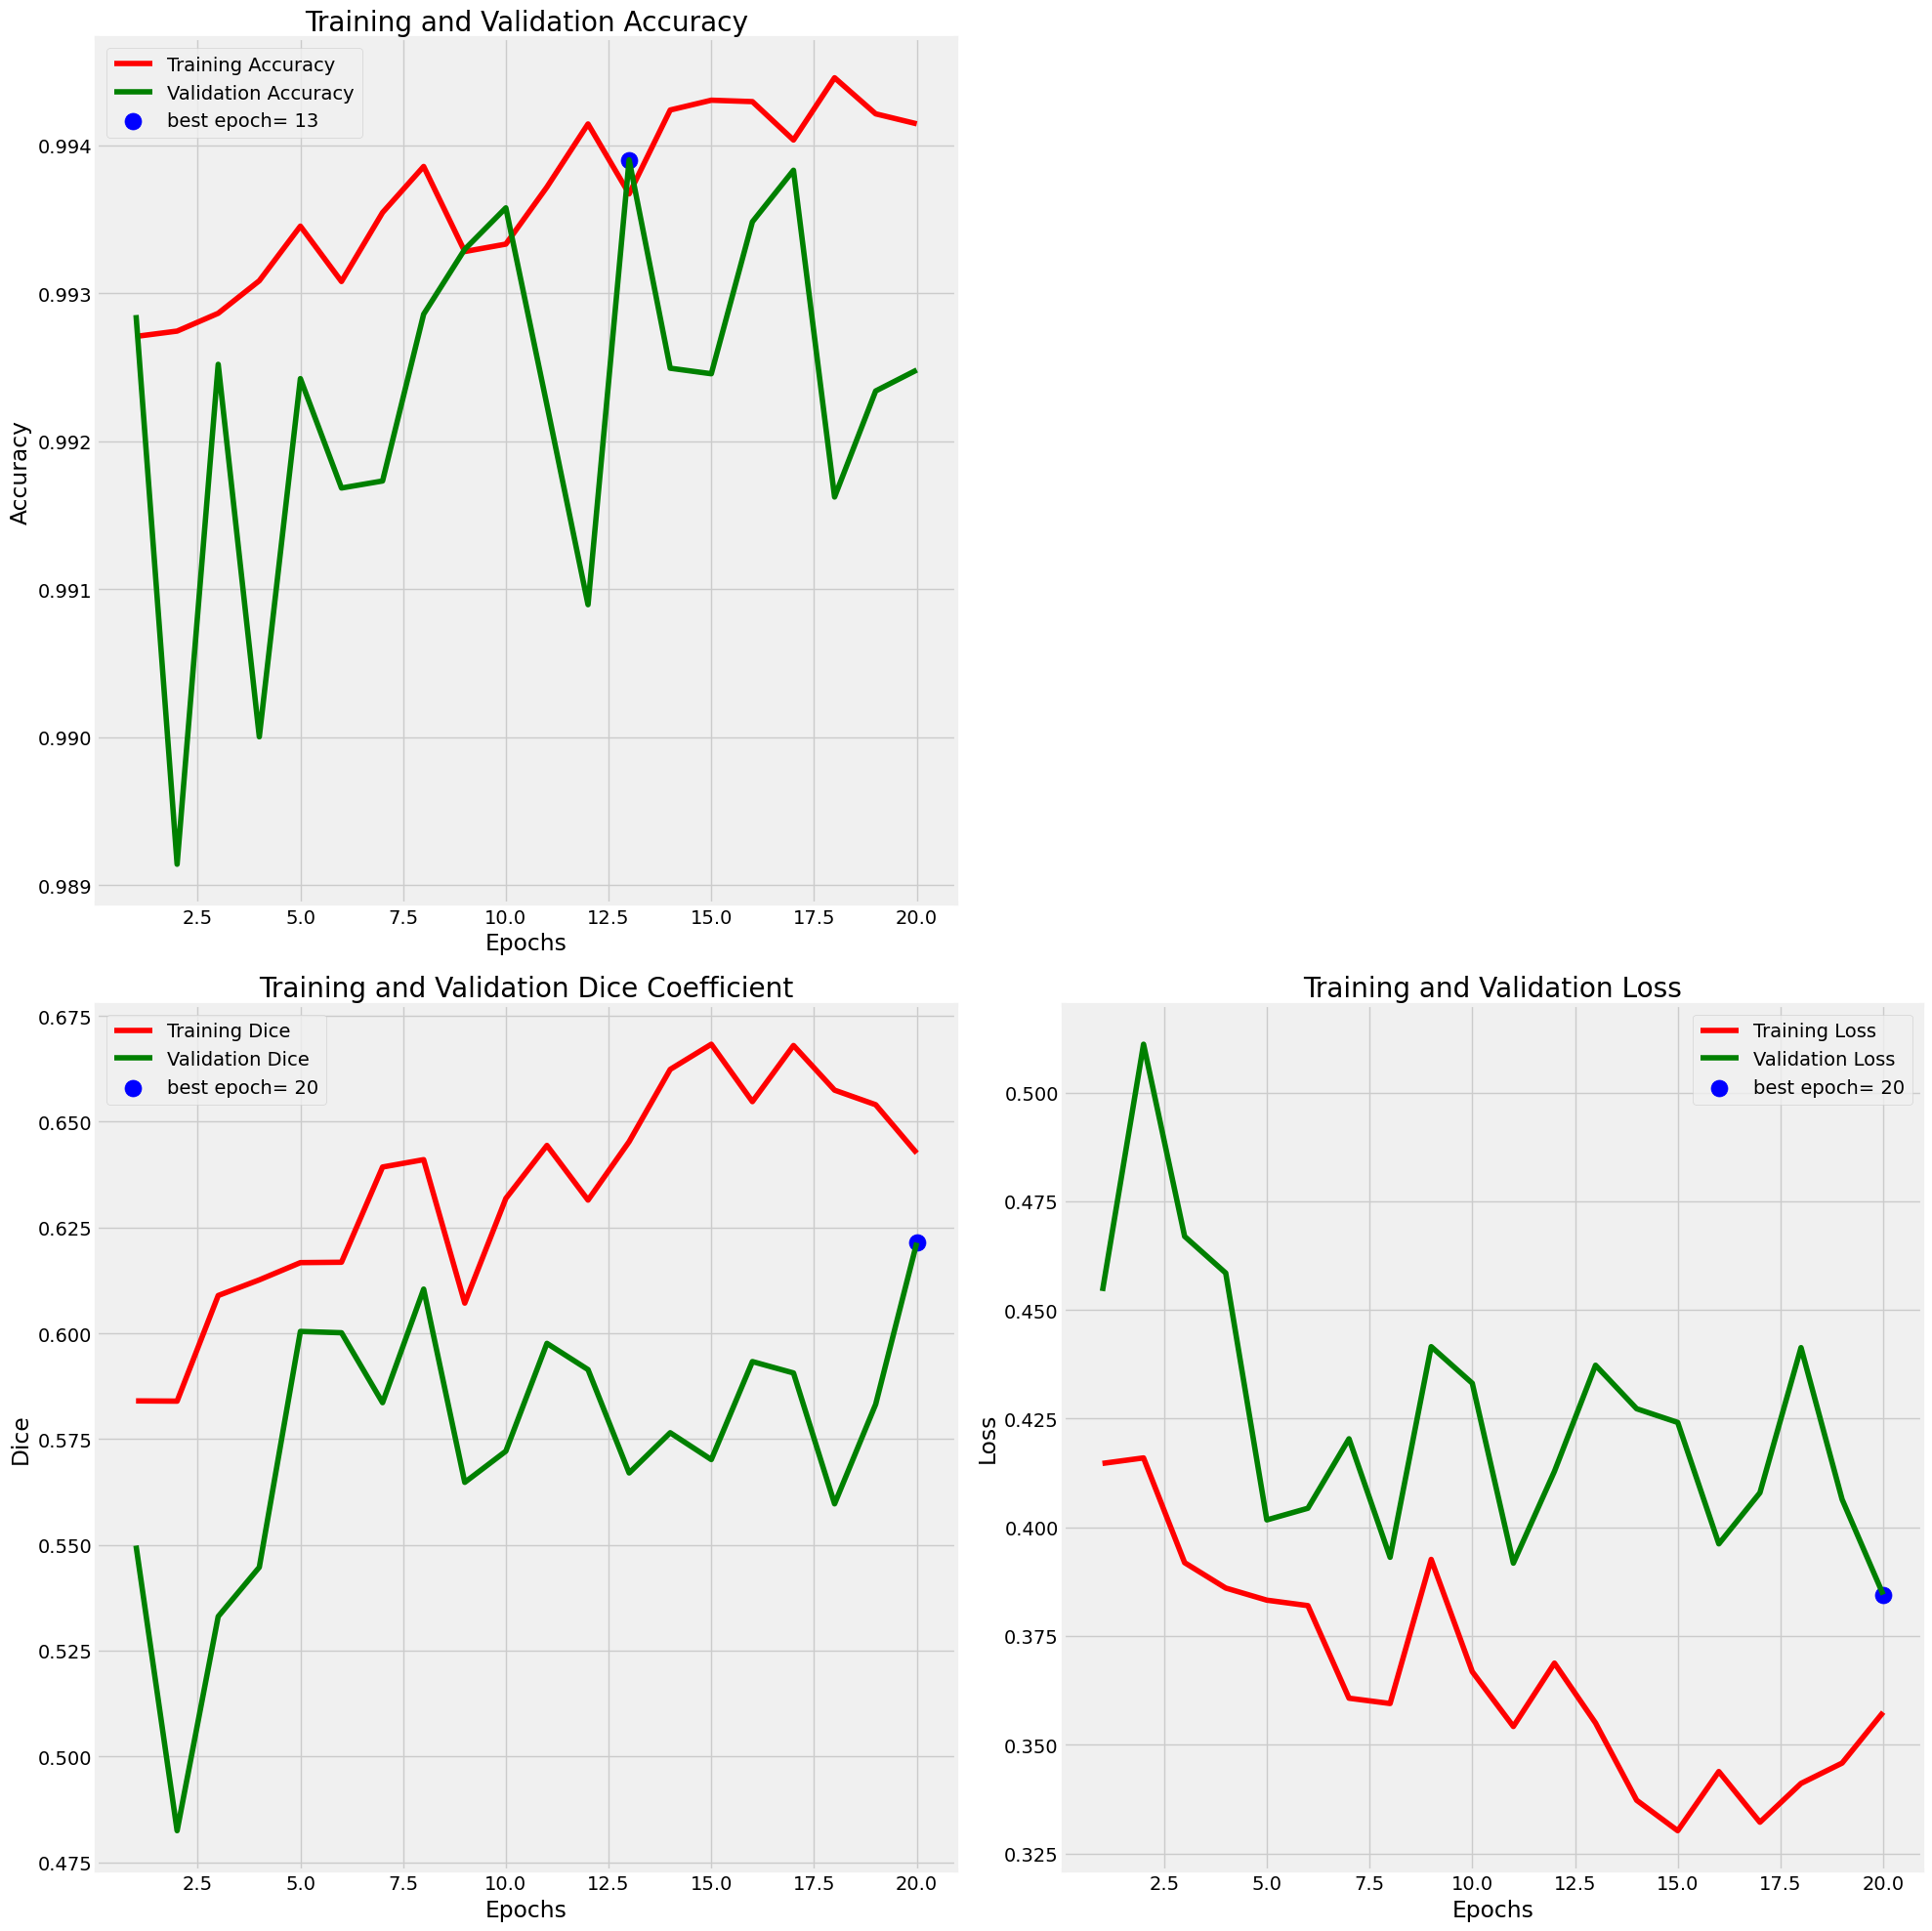

In [ ]:
plot_training(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/Brain_Tumor_Segmentation.h5')

In [ ]:
train_score = model.evaluate(train_gen, steps=math.ceil(len(train_df) / 10))
val_score = model.evaluate(val_gen, steps=math.ceil(len(val_df) / 10))
test_score = model.evaluate(test_gen, steps=math.ceil(len(test_df) / 10))

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train Dice: ", train_score[2])
print('-' * 20)

print("Valid Loss: ", val_score[0])
print("Valid Accuracy: ", val_score[1])
print("Valid Dice: ", val_score[2])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test Dice: ", test_score[2])

315/315 ━━━━━━━━━━━━━━━━━━━━ 70s 221ms/step - accuracy: 0.9937 - dice_coef: 0.6420 - loss: 0.3591
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9925 - dice_coef: 0.6322 - loss: 0.3690
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9938 - dice_coef: 0.6305 - loss: 0.3697
Train Loss:  0.3631528913974762
Train Accuracy:  0.6376112699508667
Train Dice:  0.9938578605651855
--------------------
Valid Loss:  0.37022820115089417
Valid Accuracy:  0.636134147644043
Valid Dice:  0.9925708174705505
--------------------
Test Loss:  0.36762863397598267
Test Accuracy:  0.6356936693191528
Test Dice:  0.9938533306121826


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


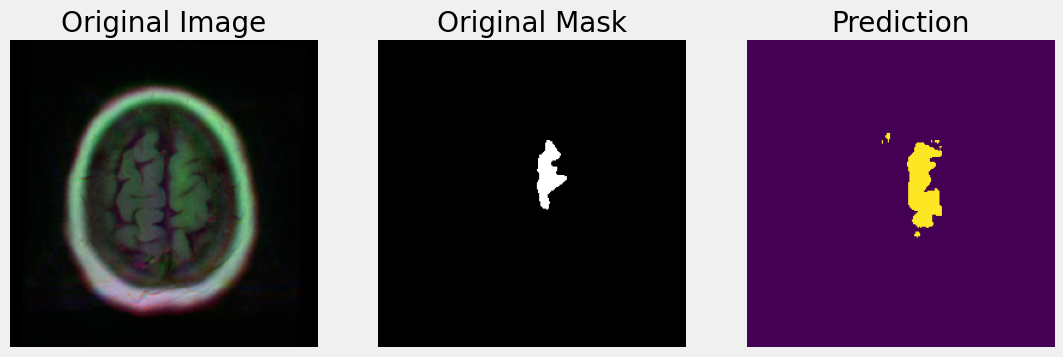

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


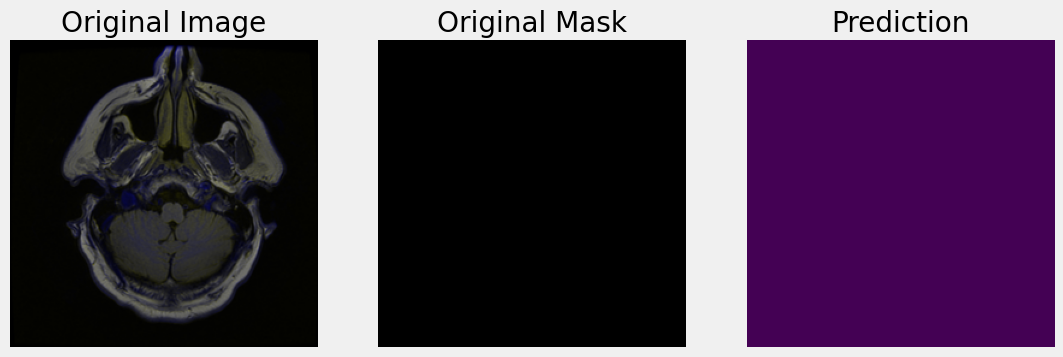

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


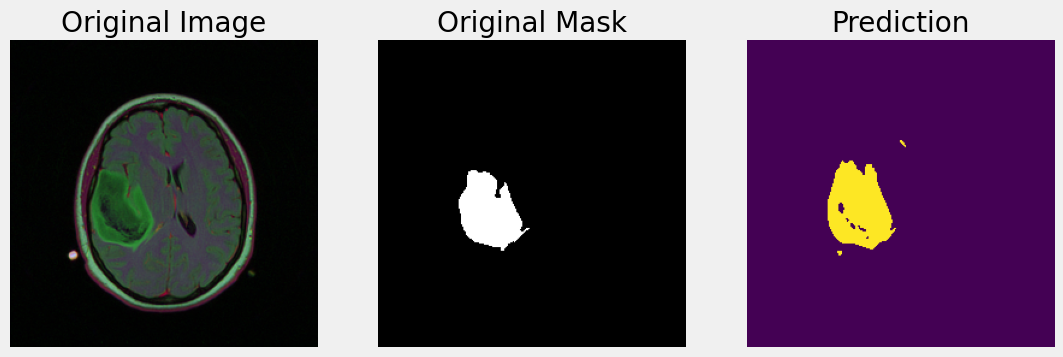

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


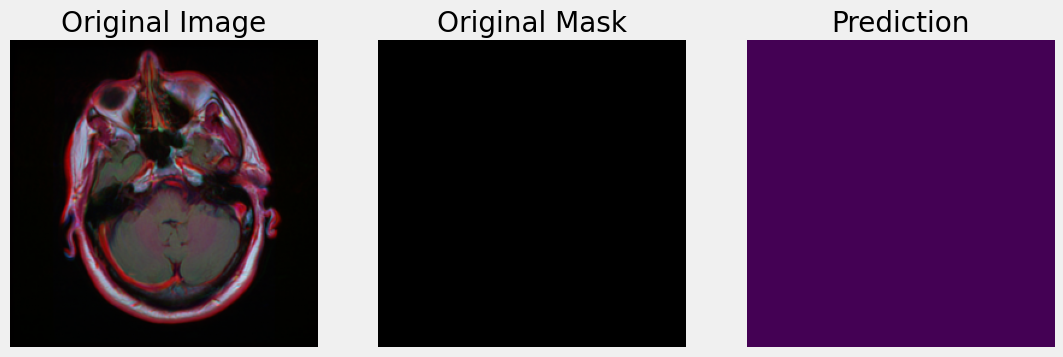

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


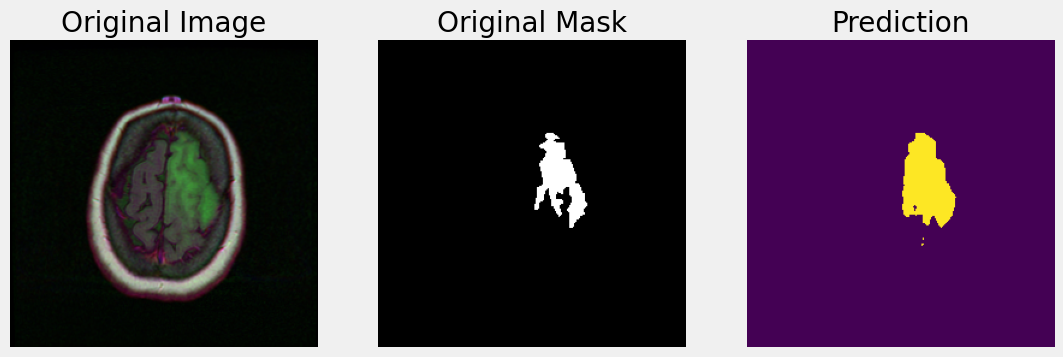

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


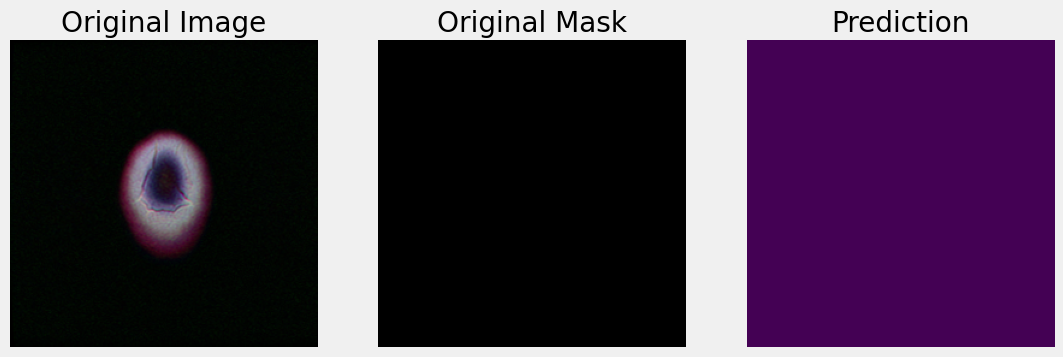

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


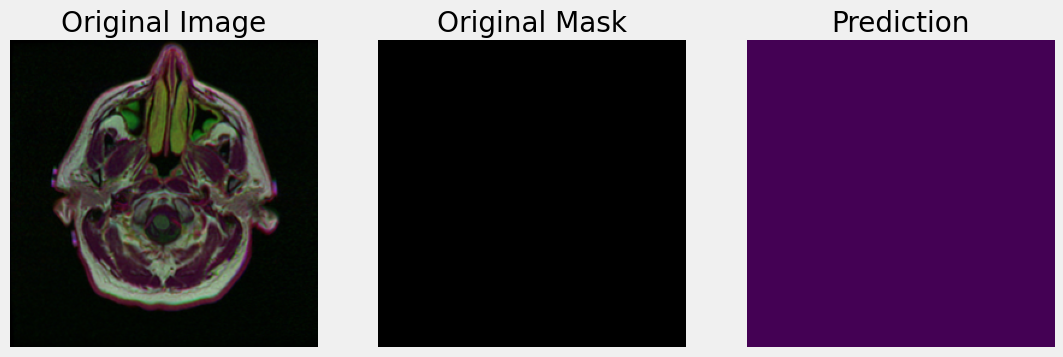

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


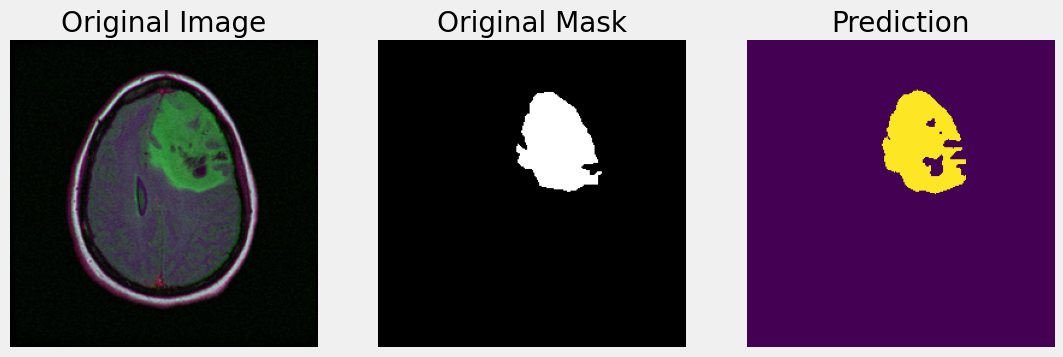

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


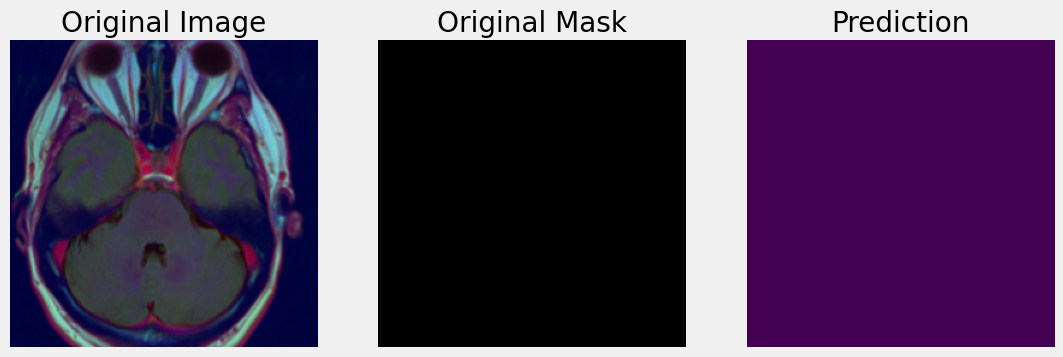

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


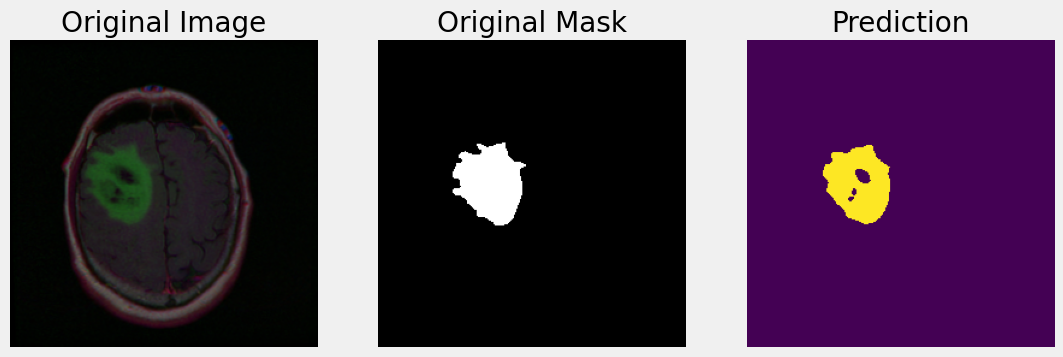

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


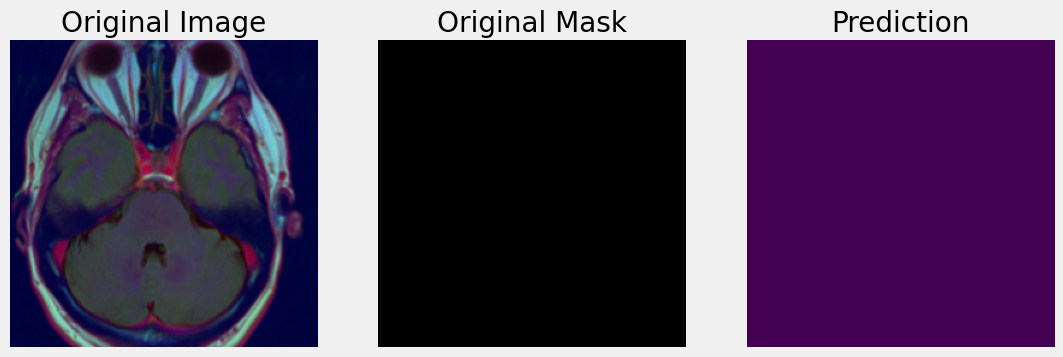

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


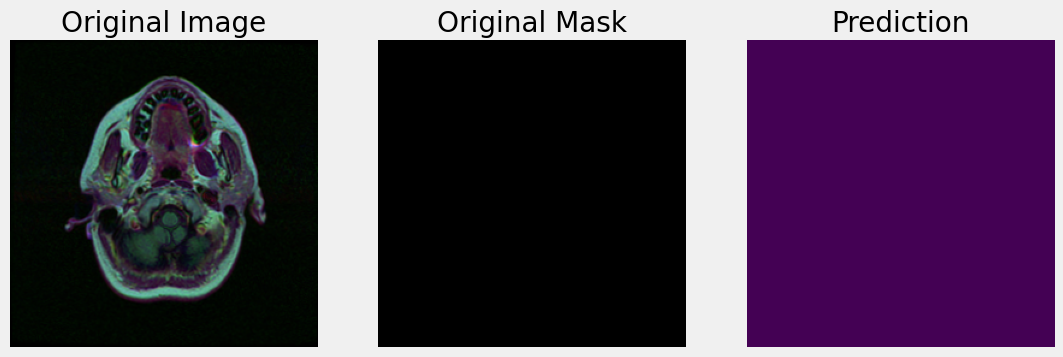

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


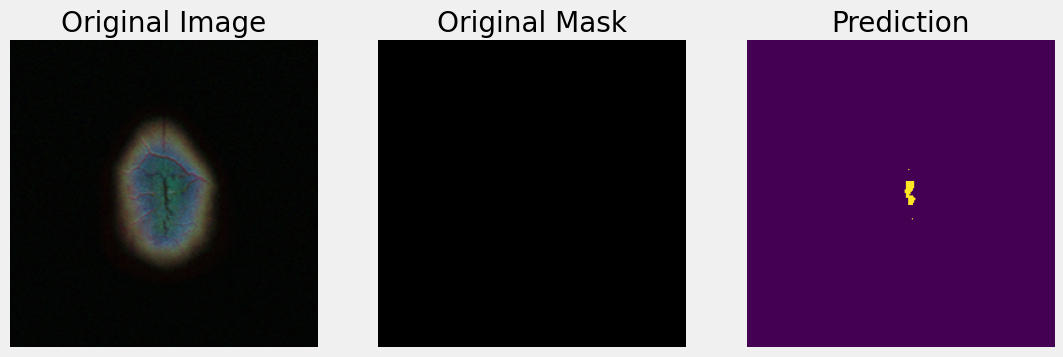

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


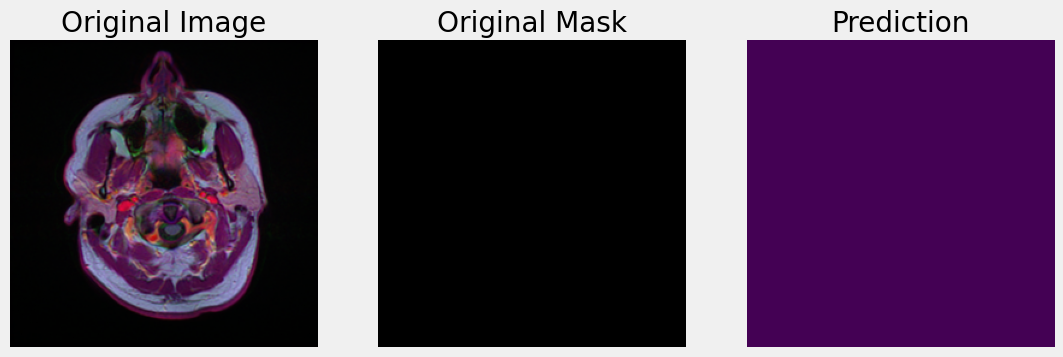

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


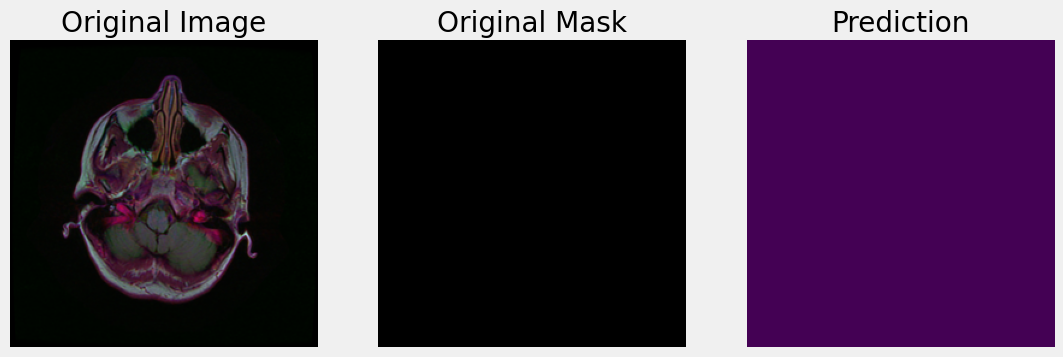

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


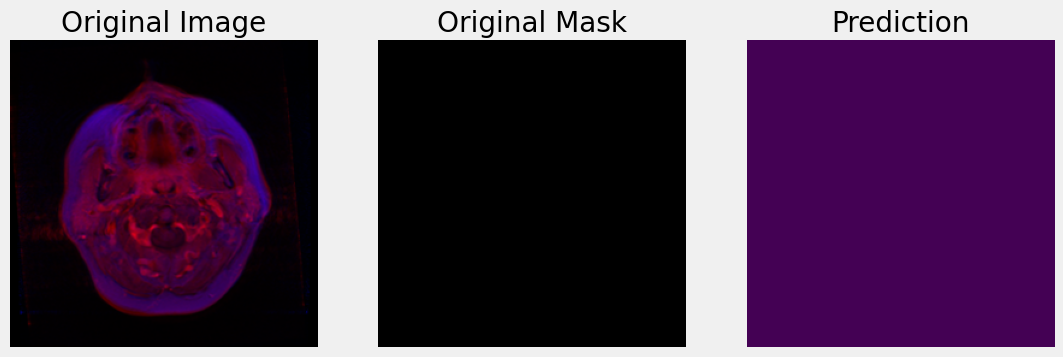

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


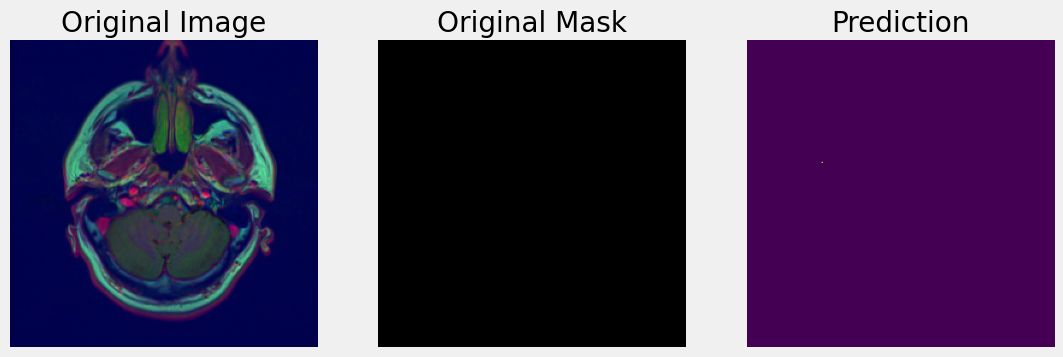

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


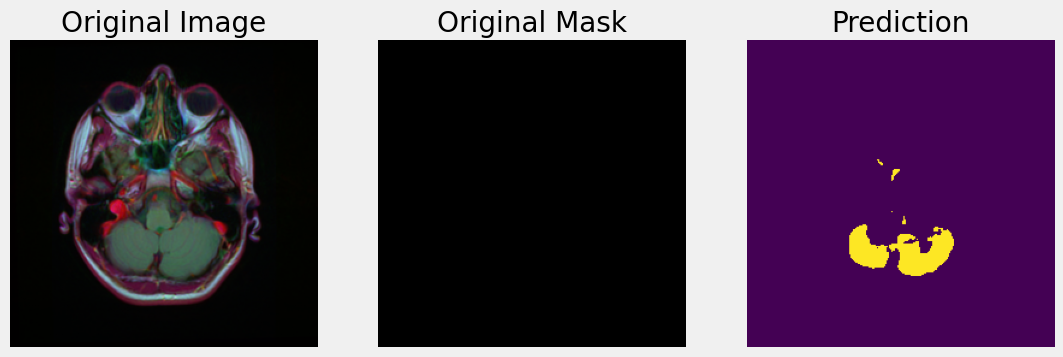

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


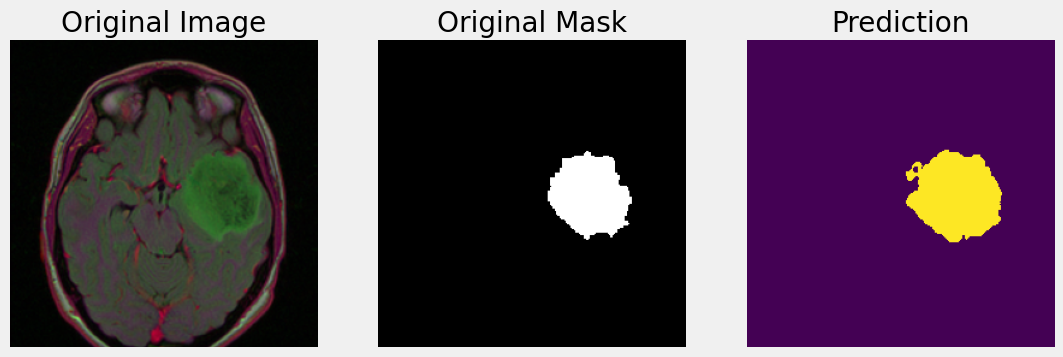

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


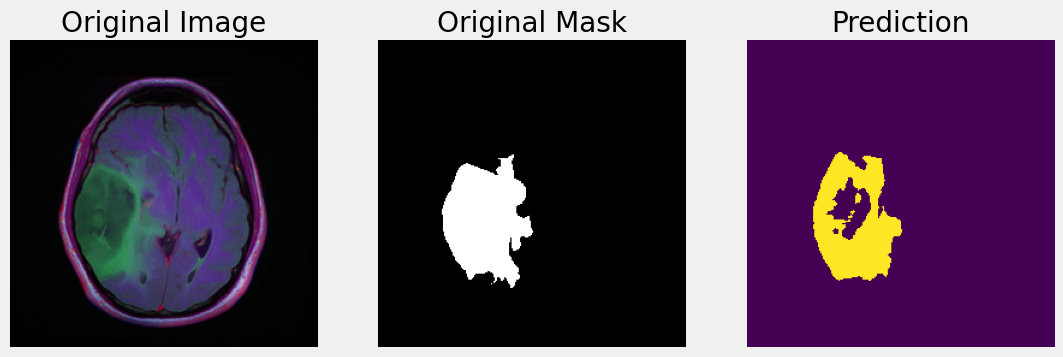

In [ ]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['Image'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['Mask'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

In [ ]:
def unet2(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), padding="same")(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    c1 = Conv2D(32, (3, 3), padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding="same")(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)
    c2 = Conv2D(64, (3, 3), padding="same")(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), padding="same")(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)
    c3 = Conv2D(128, (3, 3), padding="same")(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    # Decoder
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), padding="same")(u1)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)
    c4 = Conv2D(64, (3, 3), padding="same")(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), padding="same")(u2)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)
    c5 = Conv2D(32, (3, 3), padding="same")(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c5)

    return Model(inputs, outputs)


In [ ]:
model2 = unet2()
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model2.compile(
    optimizer=Adam(),
    loss=dice_loss,
    metrics=[dice_coef, 'accuracy']
)

history2 = model2.fit(
          train_gen,
          validation_data=val_gen,
          epochs=40,
          steps_per_epoch=math.ceil(len(train_df) / 10),
          validation_steps=math.ceil(len(val_df) / 10),
          callbacks=[early_stop],
          verbose = 1
          )

Epoch 1/40
315/315 ━━━━━━━━━━━━━━━━━━━━ 97s 273ms/step - accuracy: 0.9251 - dice_coef: 0.1872 - loss: 0.8121 - val_accuracy: 0.9896 - val_dice_coef: 0.0245 - val_loss: 0.9752
Epoch 2/40
315/315 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - accuracy: 0.9895 - dice_coef: 0.4550 - loss: 0.5458 - val_accuracy: 0.9919 - val_dice_coef: 0.4908 - val_loss: 0.5101
Epoch 3/40
315/315 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - accuracy: 0.9909 - dice_coef: 0.5282 - loss: 0.4701 - val_accuracy: 0.9905 - val_dice_coef: 0.5429 - val_loss: 0.4477
Epoch 4/40
315/315 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.9925 - dice_coef: 0.5546 - loss: 0.4435 - val_accuracy: 0.9924 - val_dice_coef: 0.5610 - val_loss: 0.4416
Epoch 5/40
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 263ms/step - accuracy: 0.9918 - dice_coef: 0.5562 - loss: 0.4420 - val_accuracy: 0.9916 - val_dice_coef: 0.5959 - val_loss: 0.4041
Epoch 6/40
315/315 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - accuracy: 0.9927 - dice_coef: 0.5796 - loss: 0.4185 - val_accuracy: 

In [ ]:
train_score = model2.evaluate(train_gen, steps=math.ceil(len(train_df) / 10))
val_score = model2.evaluate(val_gen, steps=math.ceil(len(val_df) / 10))
test_score = model2.evaluate(test_gen, steps=math.ceil(len(test_df) / 10))

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train Dice: ", train_score[2])
print('-' * 20)

print("Valid Loss: ", val_score[0])
print("Valid Accuracy: ", val_score[1])
print("Valid Dice: ", val_score[2])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test Dice: ", test_score[2])

315/315 ━━━━━━━━━━━━━━━━━━━━ 68s 216ms/step - accuracy: 0.9954 - dice_coef: 0.6818 - loss: 0.3192
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9928 - dice_coef: 0.6381 - loss: 0.3631
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9944 - dice_coef: 0.6605 - loss: 0.3383
Train Loss:  0.3162626326084137
Train Accuracy:  0.6843827366828918
Train Dice:  0.9952418804168701
--------------------
Valid Loss:  0.33455538749694824
Valid Accuracy:  0.6695999503135681
Valid Dice:  0.9935933351516724
--------------------
Test Loss:  0.32882198691368103
Test Accuracy:  0.6594464182853699
Test Dice:  0.9945208430290222


In [ ]:
model2.save('/content/drive/MyDrive/Brain_Tumor_Segmentation2.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


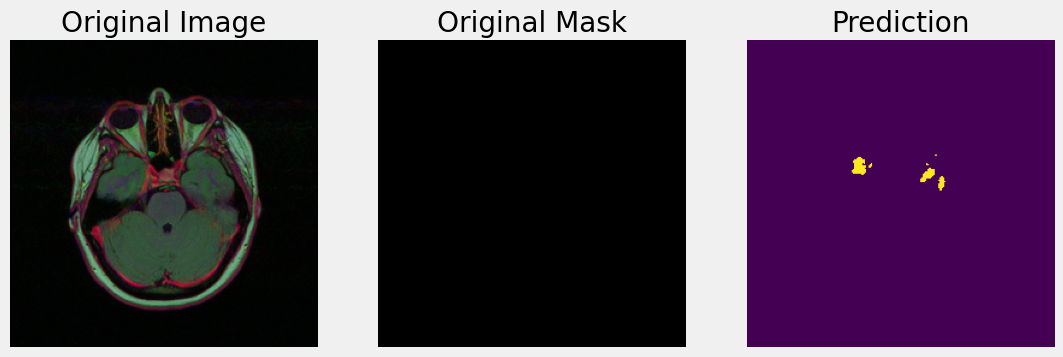

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


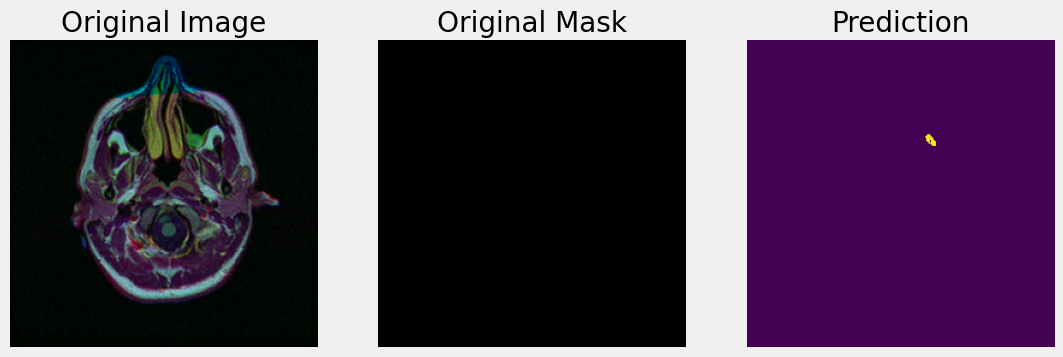

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


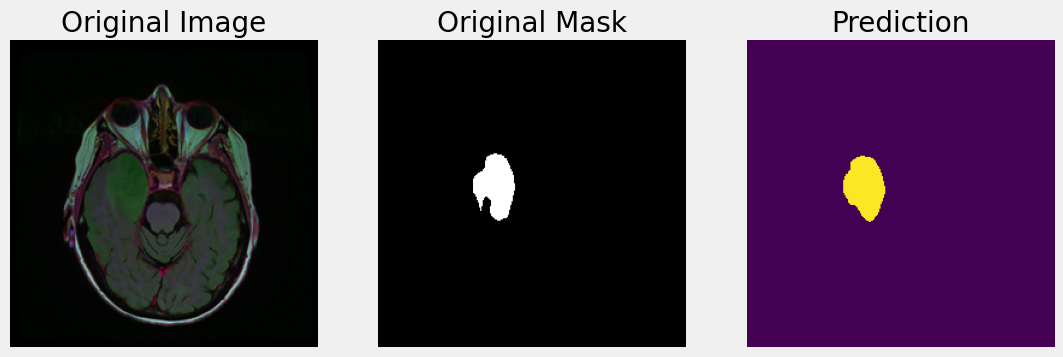

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


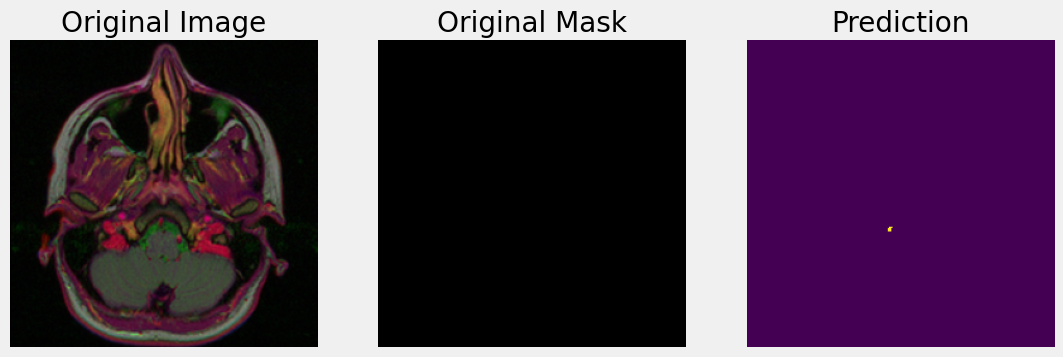

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


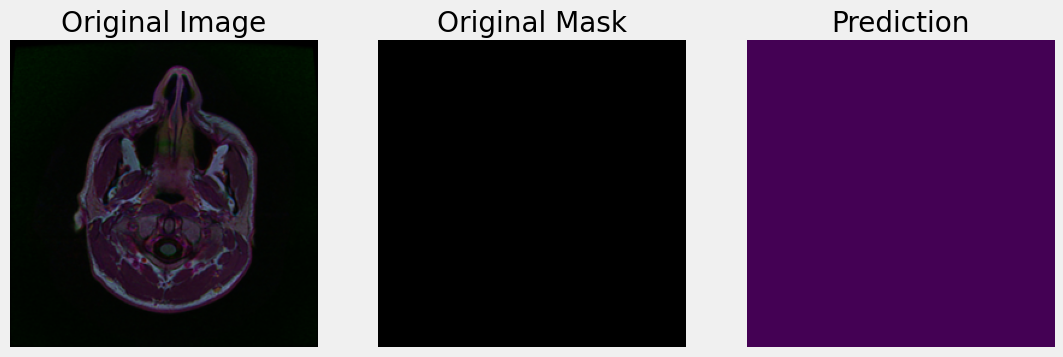

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


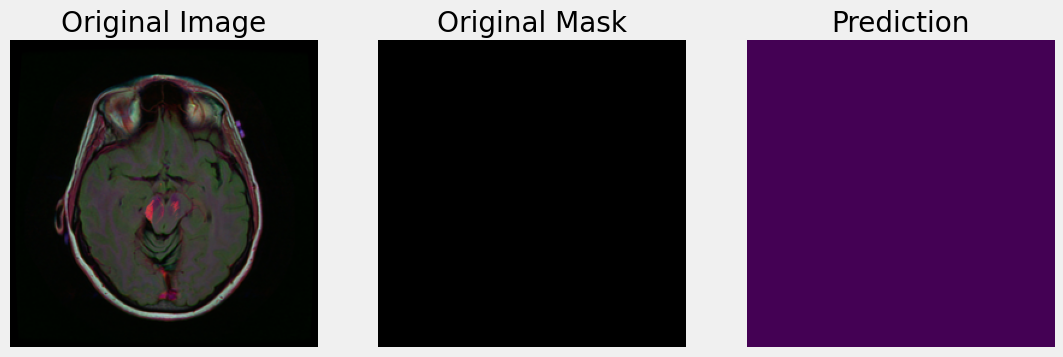

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


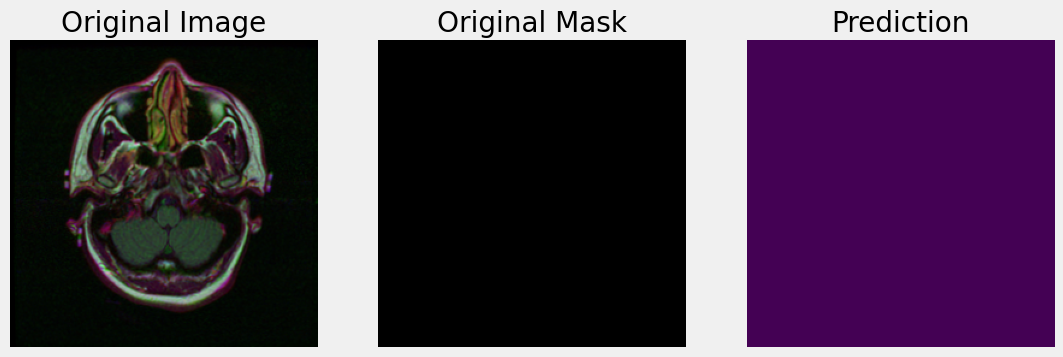

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


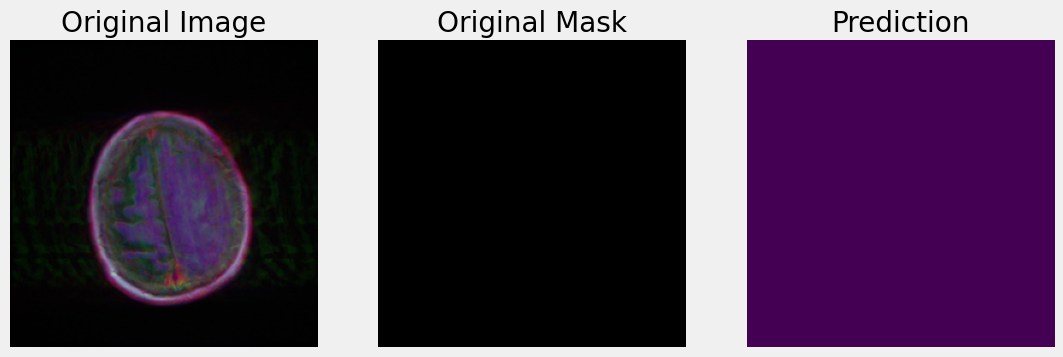

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


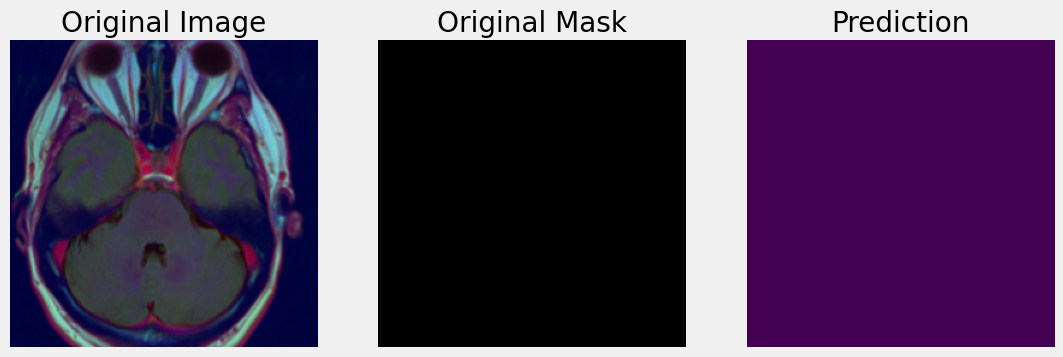

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


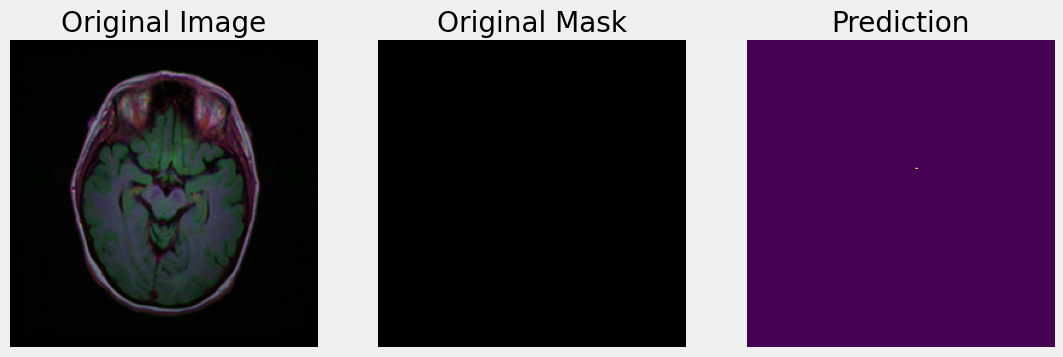

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


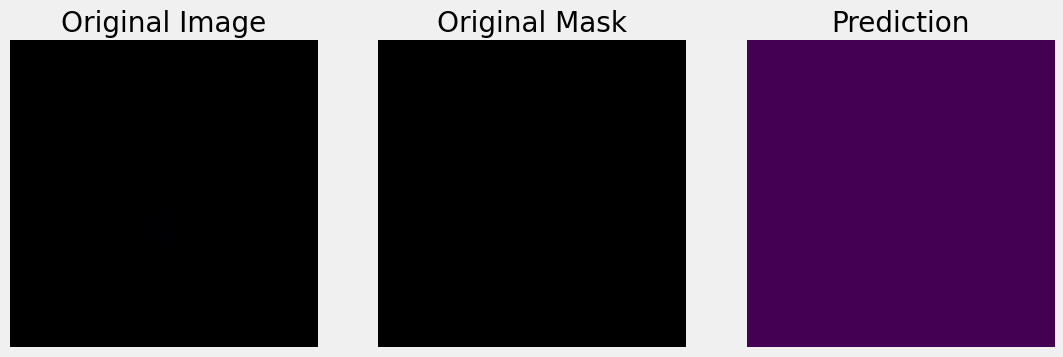

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


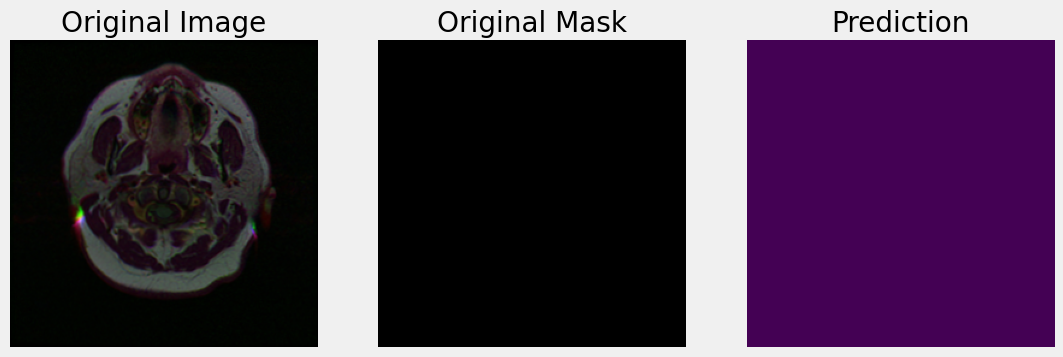

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


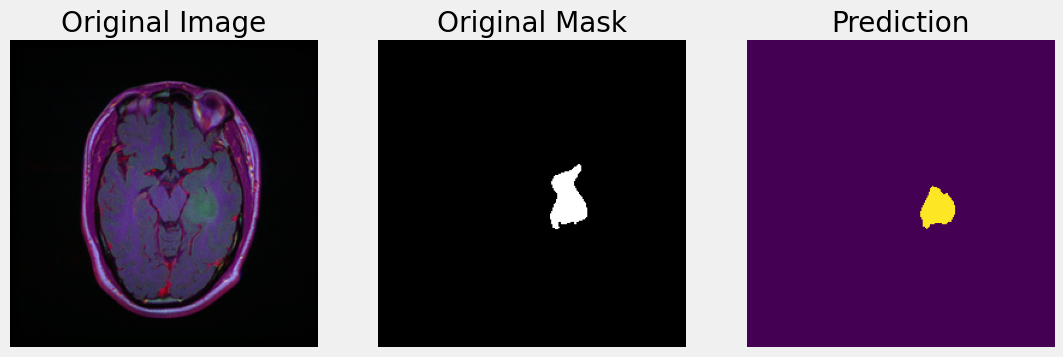

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


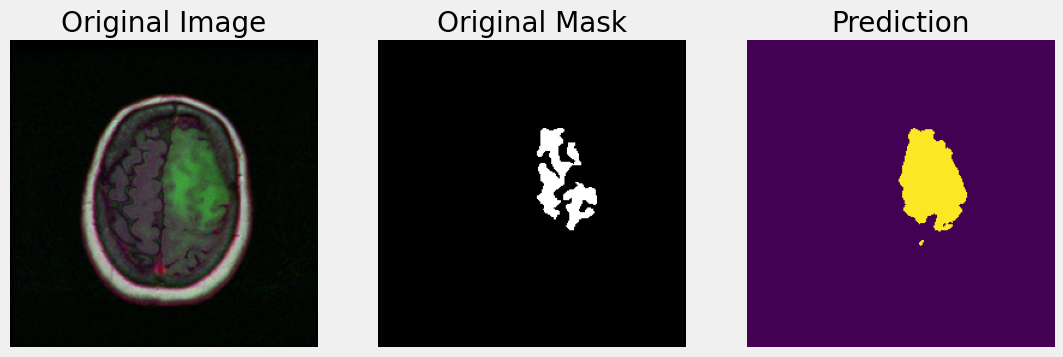

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


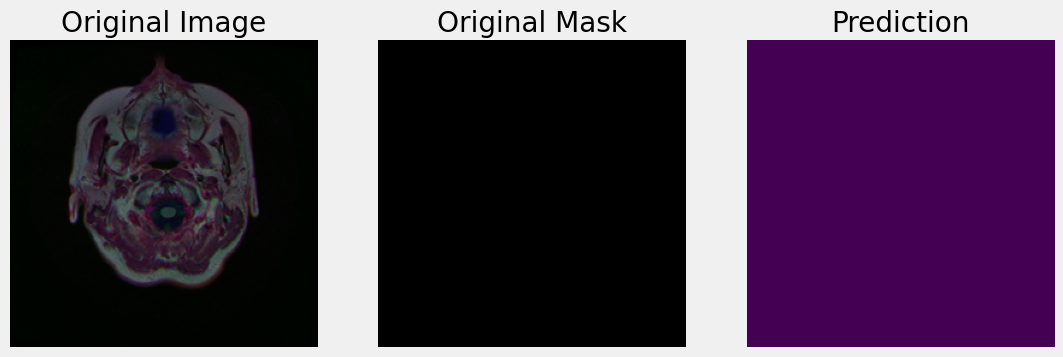

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


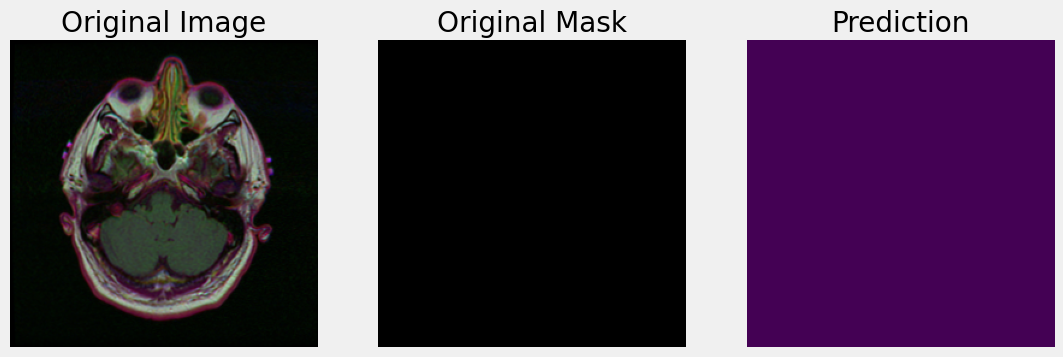

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


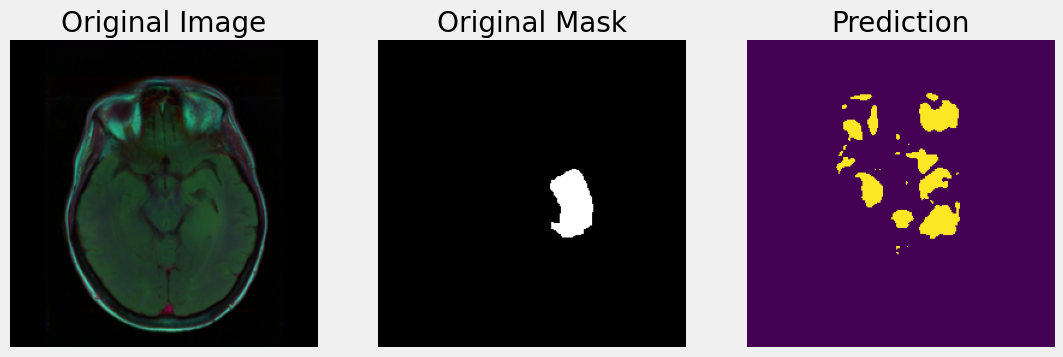

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


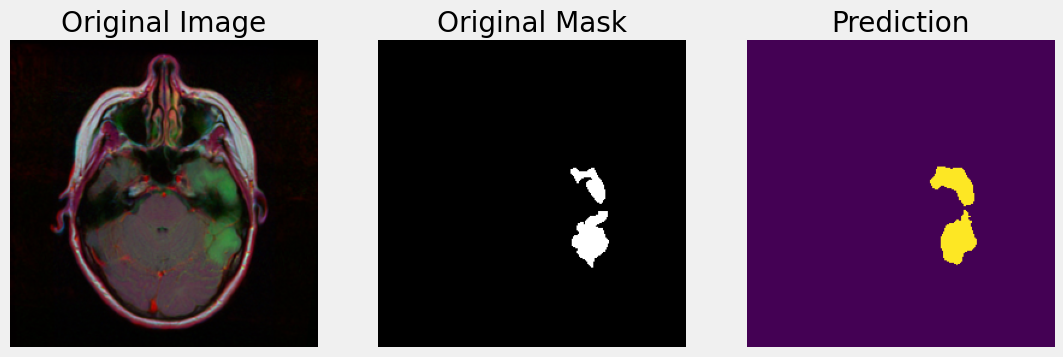

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


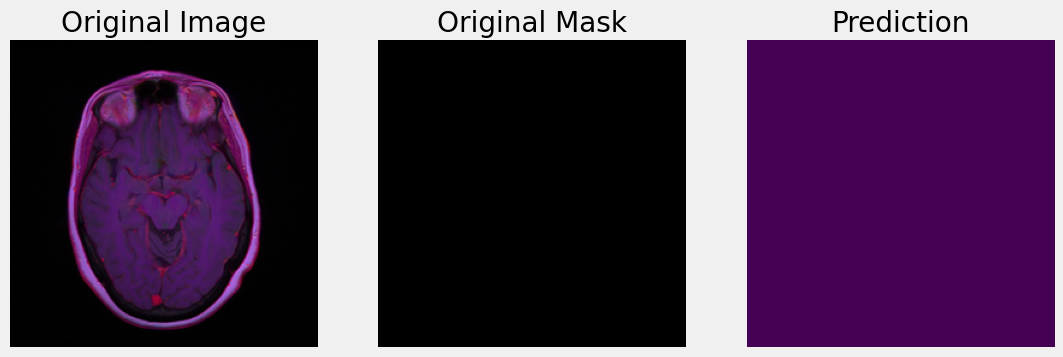

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


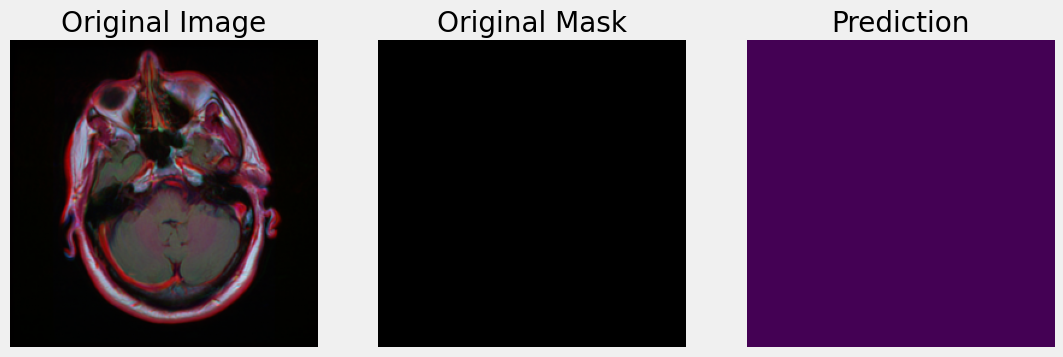

In [ ]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['Image'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['Mask'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')

    plt.show()